# setup

In [ ]:
# %%capture
# !pip install bertopic
# !pip install bertopic --no-build-isolation --no-binary :all: # in case of conflicting with numpy

# load data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("sent_tweet_data.csv")
data.head()

,Tweet_Id,Tweet,sentiment_analysis,sentiment,score
0,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,"('negative', 0.8987942934036255)",negative,0.898794
1,1.598104e+18,"Apparently ""I've had COVID for over a week and...","('negative', 0.5844972133636475)",negative,0.584497
2,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,"('negative', 0.7049756646156311)",negative,0.704976
3,1.598103e+18,They're dropping the sequel to COVID baby wooo...,"('neutral', 0.5086733102798462)",neutral,0.508673
4,1.598101e+18,@1goodtern They drop dead one by one of post C...,"('negative', 0.47382649779319763)",negative,0.473826


## positive data 

In [3]:
# get the tweet text and sentiment columns whre sentiment is positive as list
positive_data = data[data["sentiment"] == "positive"]
positive_data.head()


,Tweet_Id,Tweet,sentiment_analysis,sentiment,score
8,1.598098e+18,"My friend spencer has covid, good thing he ate...","('positive', 0.48467978835105896)",positive,0.484680
16,1.598092e+18,"""I had my baby shower here. Very big space, th...","('positive', 0.9333032369613647)",positive,0.933303
23,1.598088e+18,"Nat de covid 😭✨ Se cuide, baby https://t.co/yE...","('positive', 0.7633681893348694)",positive,0.763368
36,1.598079e+18,Get Well Soon my baby 🥹🍼 I know you're strong ...,"('positive', 0.947133481502533)",positive,0.947133
75,1.598065e+18,There’s a chosen family baby I know who’s just...,"('positive', 0.5353631377220154)",positive,0.535363


In [4]:
positive_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45263 entries, 8 to 446181
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tweet_Id            45263 non-null  float64
 1   Tweet               45263 non-null  object 
 2   sentiment_analysis  45263 non-null  object 
 3   sentiment           45263 non-null  object 
 4   score               45263 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.1+ MB


In [5]:
positive_tweets = positive_data["Tweet"].tolist()

In [6]:
len(positive_tweets)

45263

In [7]:
from bertopic import BERTopic

Topic Model Spesifications:  
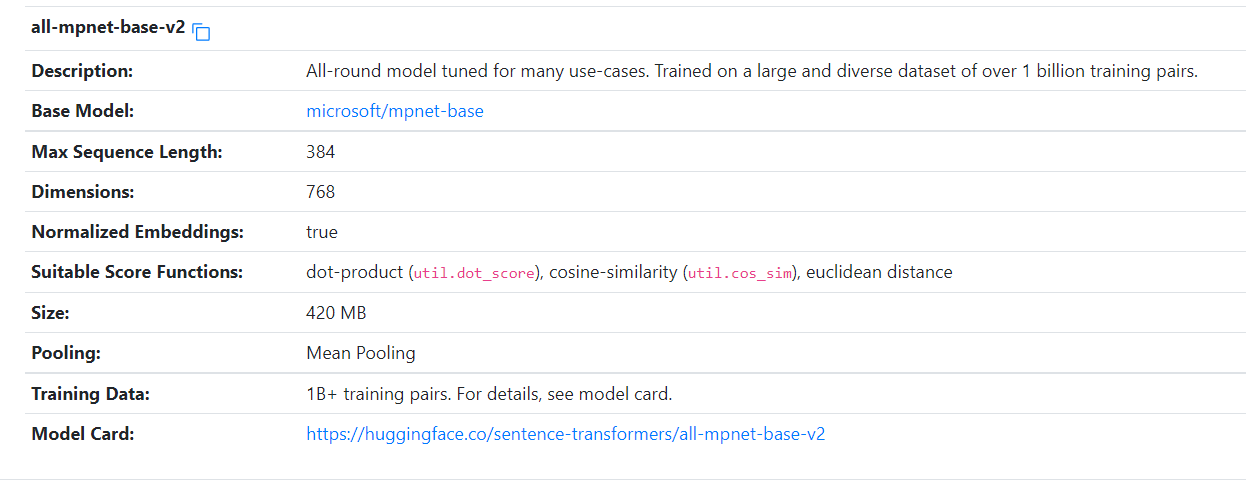

In [8]:
topic_model = BERTopic(verbose=True, embedding_model="all-mpnet-base-v2", min_topic_size=40,  calculate_probabilities=True)

In [9]:
topics, probs = topic_model.fit_transform(positive_tweets)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1415 [00:00<?, ?it/s]

2022-12-19 02:34:46,810 - BERTopic - Transformed documents to Embeddings
2022-12-19 02:35:29,035 - BERTopic - Reduced dimensionality
2022-12-19 02:36:04,639 - BERTopic - Clustered reduced embeddings


fit_transform method takes 91 minutes by using 8 core cpu machine.

In [10]:
freq = topic_model.get_topic_info()

In [11]:
freq.head(20)

,Topic,Count,Name
0,-1,22520,-1_and_the_to_covid
1,0,2227,0_birth_woman_her_anniversary
2,1,986,1_shot_vaccine_booster_got
3,2,882,2_vaccination_vaccine_pregnancy_data
4,3,788,3_biden_trump_formula_president
5,4,703,4_pregnancy_study_19_on
6,5,681,5_my_her_see_so
7,6,625,6_outside_music_concert_song
8,7,576,7_baby_you_covid_congrats
9,8,478,8_care_midwives_health_maternal


In [12]:
topic_model.get_topic(0)  # Select the most frequent topic

[('birth', 0.014008870894910265),
 ('woman', 0.011975636107843381),
 ('her', 0.010944842283919332),
 ('anniversary', 0.01087209353040012),
 ('19', 0.010825317381149934),
 ('https', 0.010599046601469056),
 ('co', 0.01059453048509857),
 ('coma', 0.010427683093173892),
 ('mother', 0.01016244781919584),
 ('story', 0.009361770834231476)]

In [13]:
topic_model.get_topic(1)

[('shot', 0.01947513640689644),
 ('vaccine', 0.017915706124880422),
 ('booster', 0.016930961243205256),
 ('got', 0.016581235371256043),
 ('my', 0.012960174849314424),
 ('first', 0.010871986919091702),
 ('flu', 0.009863887132703255),
 ('today', 0.00960700622754637),
 ('vaccinated', 0.009492207448380852),
 ('shots', 0.009297829421114893)]

In [14]:
topic_model.get_topic(2)

[('vaccination', 0.02228798149140142),
 ('vaccine', 0.017471619608199304),
 ('pregnancy', 0.017107554432163313),
 ('data', 0.016695004663836062),
 ('women', 0.01657663446028054),
 ('vaccines', 0.016149012947541),
 ('pregnant', 0.014411883836976225),
 ('co', 0.013225386035366287),
 ('https', 0.013159456645915961),
 ('in', 0.009959244239715923)]

# Topic Visualization

In [15]:
topic_model.visualize_topics()

In [16]:
topic_model.visualize_barchart()

In [17]:
topic_model.visualize_heatmap()

In [18]:
topic_model.visualize_term_rank()